In [1]:
# Import dependencies and APIs
# QUESTION: What influences a state's ability to control Covid-19?

import pandas as pd
import numpy as np
import requests
import json
from census import Census
from us import states
import matplotlib.pyplot as plt
import scipy.stats as st
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
from scipy.stats import linregress

from config import covidkey
from config import censuskey
from config import gkey
c = Census(censuskey, year=2013)
censuskey


'04f514dfbd7422da53425fd0190e7284a2214b9d'

In [2]:
# access census api
census_url=f"api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key={censuskey}"

census_url

'api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key=04f514dfbd7422da53425fd0190e7284a2214b9d'

In [3]:
# access covid now api
# https://api.covidactnow.org/v2/cbsas.timeseries.csv?apiKey={04f514dfbd7422da53425fd0190e7284a2214b9d}
covid_url = f"https://api.covidactnow.org/v2/states.timeseries.json?apiKey={covidkey}"
covid_url2 = f"https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={covidkey}"
covid_url2

'https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=72b8f0e0bd344e619f281fe9036fff5c'

In [4]:
# import covid state historical data
covid_historic = requests.get(covid_url).json()

In [5]:
# import historical timeseries data
covid_historic2 = pd.read_csv("CSVs/states.timeseries.csv")

In [6]:
# Filter the DF down to the columns of interest
# There are null values for dates before the first measure of each state, replace nulls with 0
covid_historic_df1 = covid_historic2.loc[:,['date', 'state', 'actuals.cases', 'actuals.deaths', 'actuals.newDeaths', 'actuals.newCases']]
covid_historic_df1 = covid_historic_df1.fillna(0)

In [7]:
#Import covid summary by state data
covidnow_st_df=pd.read_csv("CSVs/Covid_Now_CSVs/states.csv")

#covidnow_st_df.head()

In [8]:
#Import lockdown duration by state
lockdown_df=pd.read_csv("CSVs/LockdownDuration.csv")

In [9]:
# Import State Demographics CSV File From the CORGIS Dataset Project (Ryan Whitcomb, 2016)
population_df=pd.read_csv("CSVs/state_demographics.csv")


population_df['State Abbrev'] = ''
population_df.drop(labels=[0],axis=0,inplace=True)

In [10]:
# Find the state abbreviation for each state for merging
states_list = []
for x in population_df['State']:
    St_list = states.lookup(x).abbr
    states_list.append(St_list)
        
population_df['state'] = states_list
population_df.head()

,State,Age.Percent 65 and Older,Age.Percent Under 18 Years,Age.Percent Under 5 Years,Education.Bachelor's Degree or Higher,Education.High School or Higher,Employment.Nonemployer Establishments,Employment.Private Non-farm Employment,Employment.Private Non-farm Employment Percent Change,Employment.Private Non-farm Establishments,...,Sales.Retail Sales per Capita,Employment.Firms.American Indian-Owned,Employment.Firms.Asian-Owned,Employment.Firms.Black-Owned,Employment.Firms.Hispanic-Owned,Employment.Firms.Native Hawaiian and Other Pacific Islander-Owned,Employment.Firms.Total,Employment.Firms.Women-Owned,State Abbrev,state
1,Alabama,15.3,22.8,6.1,22.6,83.1,311578,1603100,1.1,97578,...,12364,0.8,1.8,14.8,1.2,0.1,382350,28.1,,AL
2,Alaska,9.4,25.3,7.4,27.5,91.6,52991,266627,3.3,20519,...,13635,10.0,3.1,1.5,0.0,0.3,68728,25.9,,AK
3,Arizona,15.9,24.1,6.4,26.9,85.7,420233,2173205,1.8,132762,...,13637,1.9,3.3,2.0,10.7,0.0,491529,28.1,,AZ
4,Arkansas,15.7,23.8,6.5,20.1,83.7,191530,978094,0.0,64772,...,11602,1.1,1.4,5.5,2.3,0.1,238994,24.5,,AR
5,California,12.9,23.6,6.5,30.7,81.2,2983996,13401863,3.5,874243,...,12561,1.3,14.9,4.0,16.5,0.3,3425510,30.3,,CA


In [11]:
# Filter DF for columns of interest
filtered_pop_df = population_df.loc[:,['state','State','Population.Population per Square Mile']]
#filtered_pop_df.head()

In [12]:
# Merge DF's on state
merged_df = pd.merge(filtered_pop_df, covidnow_st_df, on="state")
#merged_df.head()

In [13]:
# Pull total state population from census api
census_data = c.acs5.get('B01003_001E', {'for': 'state:*'})
census_pd = pd.DataFrame(census_data)
census_pd = census_pd.rename(columns ={'B01003_001E': 'Population'})
#census_pd.head()

In [14]:
# Create an empty column for the state abbreviations
census_pd['State'] = " "

In [15]:
# Replace the state codes with abbreviations
states_list = []
for x in census_pd['state']:
    Z = states.lookup(x).abbr
    states_list.append(Z)

census_pd['State'] = states_list
census_pd.drop(labels=['state'],axis=1,inplace=True)
census_pd = census_pd.rename(columns ={'State': 'state'})
#census_pd.head()

In [16]:
# Merge population data onto the main df
final_df = pd.merge(census_pd,merged_df, on="state")
#final_df.head()

In [17]:
# Find the ratio of the total population for deaths and positive cases
final_df['Death Ratio'] = final_df['actuals.deaths']/final_df['Population']*100
final_df['Positive Ratio'] = final_df['actuals.positiveTests']/final_df['Population']*100
#final_df.head()

In [18]:
# Merge lockdown duration onto the main df
Covid_df = pd.merge(lockdown_df,final_df, on="state")
#Covid_df.describe()

In [19]:
# Filtering out pop density outlier
Covid_df = Covid_df[Covid_df['Population.Population per Square Mile'] < 5000]

The correlation between both factors is -0.06


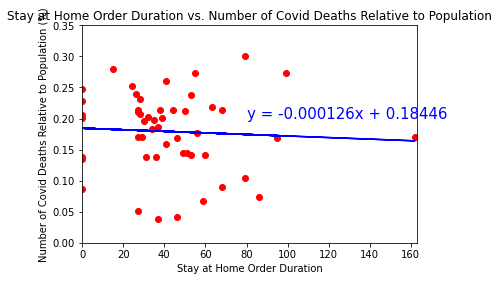

In [20]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Death Ratio'],color='red')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Stay at Home Order Duration')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population')
plt.xlim(0,163)
plt.ylim(0,0.35)
x_values = Covid_df['stay at home length']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,6)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(80,0.20),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population.png')
plt.show()

The correlation between both factors is -0.24


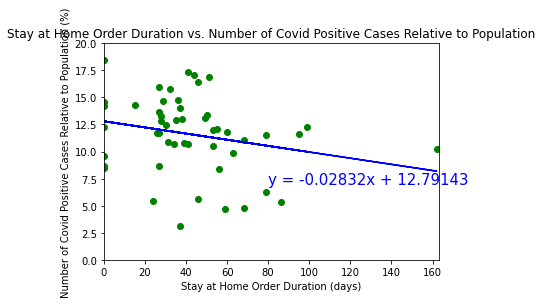

In [21]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Stay at Home Order Duration (days)')
plt.ylabel('Number of Covid Positive Cases Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0,163)
plt.ylim(0,20)
x_values = Covid_df['stay at home length']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(80,7),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is 0.44


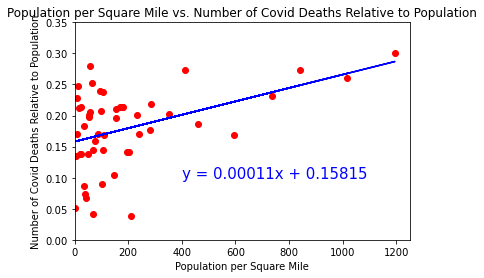

In [22]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Death Ratio'],color='red')
correlation = st.pearsonr(Covid_df['Population.Population per Square Mile'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Population per Square Mile')
plt.ylabel('Number of Covid Deaths Relative to Population')
plt.title('Population per Square Mile vs. Number of Covid Deaths Relative to Population')
plt.xlim(0,1250)
plt.ylim(0,0.35)
x_values = Covid_df['Population.Population per Square Mile']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(400,0.1),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Population per Square Mile vs. Number of Covid Deaths Relative to Population.png')
plt.show()

The correlation between both factors is 0.17


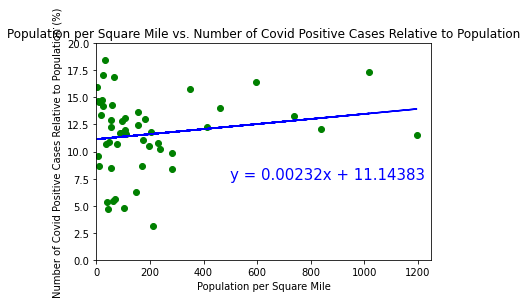

In [23]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['Population.Population per Square Mile'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Population per Square Mile')
plt.ylabel('Number of Covid Positive Cases Relative to Population (%)')
plt.title('Population per Square Mile vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0,1250)
plt.ylim(0,20)
x_values = Covid_df['Population.Population per Square Mile']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(500,7.5),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Population per Square Mile vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is -0.14


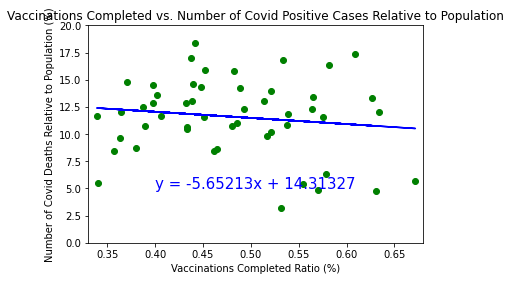

In [24]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Vaccinations Completed Ratio (%)')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Vaccinations Completed vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0.33,0.68)
plt.ylim(0,20)
x_values = Covid_df['metrics.vaccinationsCompletedRatio']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(.40,5),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Vaccination Completed vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is -0.06


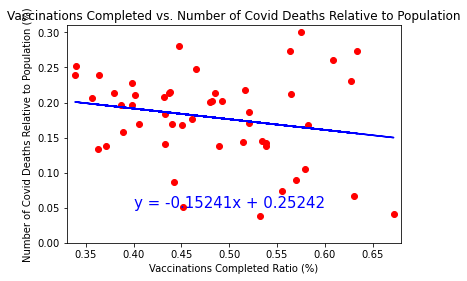

In [25]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Death Ratio'],color='red')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Vaccinations Completed Ratio (%)')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Vaccinations Completed vs. Number of Covid Deaths Relative to Population')
plt.xlim(0.33,0.68)
plt.ylim(0,0.31)
x_values = Covid_df['metrics.vaccinationsCompletedRatio']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(.40,0.05),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Vaccinations Completed vs. Number of Covid Deaths Relative to Population.png')
plt.show()

In [26]:
#Create a new df which bins the states by population density for bar graphs
#Covid_df.describe()

bins = [0,25,50,75,100,150,250,350,10000]
group_names = ['0-24','25-49','50-74','75-99','100-149','150-249','250-349','350+']
Covid_df['PopDenBins'] = pd.cut(Covid_df['Population.Population per Square Mile'], bins, labels=group_names, include_lowest=True)
Covid_df['PopDenBins'].head()

0      75-99
1       0-24
2      50-74
3      50-74
4    150-249
Name: PopDenBins, dtype: category
Categories (8, object): ['0-24' < '25-49' < '50-74' < '75-99' < '100-149' < '150-249' < '250-349' < '350+']

In [27]:
PopDen_group = Covid_df.groupby('PopDenBins')
PopDen_group['Death Ratio'].mean()

PopDenBins
0-24       0.170190
25-49      0.109848
50-74      0.188928
75-99      0.193571
100-149    0.149287
150-249    0.174154
250-349    0.197862
350+       0.237056
Name: Death Ratio, dtype: float64

In [28]:
#create latitute and longitude values from google api for use in gmaps
derived_lats= [] 
derived_longs=[]
for stateValues in Covid_df['State']:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={stateValues}&key={gkey}"
    geo_data = requests.get(target_url).json()
    derived_lats.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    derived_longs.append(geo_data["results"][0]["geometry"]["location"]["lng"])

Covid_df['Latitude'] = derived_lats
Covid_df['Longitude'] = derived_longs

In [29]:
#find the Polygon coordinates for states from gplot library
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)

In [30]:
# Renaming columns for merge
contiguous_usa = contiguous_usa.rename(columns = {'state': 'State'})

In [31]:
# Isolating columns of interest
derived_df = contiguous_usa.loc[:,['State','geometry']]

In [32]:
# mergeplot info with 
mergedGeo_df = pd.merge(derived_df, Covid_df, on="State")

In [33]:
#gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
CovidGeo = gpd.GeoDataFrame(mergedGeo_df, geometry=mergedGeo_df.geometry)
#CovidGeo.head()

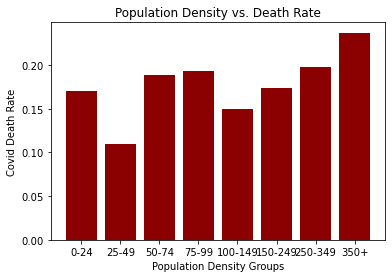

In [34]:
# Bar graph showing population density vs death rate
plt.bar(group_names, PopDen_group['Death Ratio'].mean(),color=("darkred"))
plt.title("Population Density vs. Death Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Covid Death Rate")
plt.savefig('Population Density vs. Death Rate BAR.png')
plt.show()

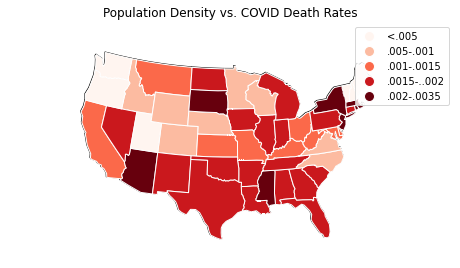

In [35]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Death Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Reds",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.005", ".005-.001", ".001-.0015",
    ".0015-..002",".002-.0035"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)
plt.title("Population Density vs. COVID Death Rates")
plt.savefig('Population Density vs. Death Rate GEO.png')

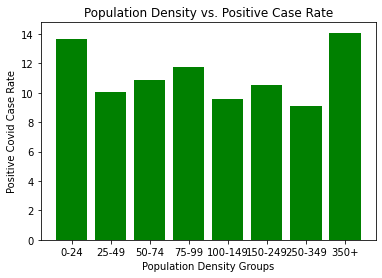

In [36]:
# Bar graph showing population density 
plt.bar(group_names, PopDen_group['Positive Ratio'].mean(),color=("green"))
plt.title("Population Density vs. Positive Case Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Positive Covid Case Rate")
plt.savefig('Population Density vs. Positive Case Rate BAR.png')
plt.show()

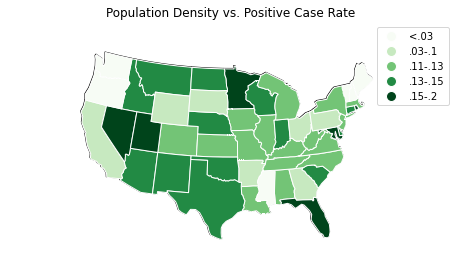

In [37]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Positive Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Greens",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.03", ".03-.1", ".11-.13",
    ".13-.15",".15-.2"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)
plt.title("Population Density vs. Positive Case Rate")
plt.savefig('Population Density vs. Positive Case Rate GEO.png')

In [38]:
#plt.bar(group_names, PopDen_group['stay at home length'].mean())

In [39]:
# Merging state pop data into historic data
covid_historic_df = pd.merge(census_pd, covid_historic_df1, on='state')
# covid_historic_df.head()

In [40]:
# Calculating ratios in relation to the population
covid_historic_df['%cases'] = covid_historic_df['actuals.cases']/covid_historic_df['Population']
covid_historic_df['%deaths'] = covid_historic_df['actuals.deaths']/covid_historic_df['Population']
covid_historic_df['%newCases'] = covid_historic_df['actuals.newCases']/covid_historic_df['Population']
covid_historic_df['%newDeaths'] = covid_historic_df['actuals.newDeaths']/covid_historic_df['Population']
#covid_historic_df.head()

In [41]:
# Making new DFs for each state's historic data
Alabama = covid_historic_df[covid_historic_df['state'] == 'AL']
Alaska = covid_historic_df[covid_historic_df['state'] == 'AK']
Arizona =  covid_historic_df[covid_historic_df['state'] == 'AZ']
Arkansas = covid_historic_df[covid_historic_df['state'] == 'AR']
California= covid_historic_df[covid_historic_df['state'] == 'CA']
Colorado= covid_historic_df[covid_historic_df['state'] == 'CO']
Connecticut= covid_historic_df[covid_historic_df['state'] == 'CT']
Delaware= covid_historic_df[covid_historic_df['state'] == 'DE']
Florida= covid_historic_df[covid_historic_df['state'] == 'FL']
Georgia= covid_historic_df[covid_historic_df['state'] == 'GA']
Hawaii= covid_historic_df[covid_historic_df['state'] == 'HI']
Idaho= covid_historic_df[covid_historic_df['state'] == 'ID']
Illinois= covid_historic_df[covid_historic_df['state'] == 'IL']
Indiana= covid_historic_df[covid_historic_df['state'] == 'IN']
Iowa= covid_historic_df[covid_historic_df['state'] == 'IA']
Kansas= covid_historic_df[covid_historic_df['state'] == 'KS']
Kentucky= covid_historic_df[covid_historic_df['state'] == 'KY']
Louisiana= covid_historic_df[covid_historic_df['state'] == 'LA']
Maine= covid_historic_df[covid_historic_df['state'] == 'ME']
Maryland= covid_historic_df[covid_historic_df['state'] == 'MD']
Massachusetts= covid_historic_df[covid_historic_df['state'] == 'MA']
Michigan= covid_historic_df[covid_historic_df['state'] == 'MI']
Minnesota= covid_historic_df[covid_historic_df['state'] == 'MN']
Mississippi= covid_historic_df[covid_historic_df['state'] == 'MS']
Missouri= covid_historic_df[covid_historic_df['state'] == 'MO']
Montana= covid_historic_df[covid_historic_df['state'] == 'MT']
Nebraska= covid_historic_df[covid_historic_df['state'] == 'NE']
Nevada= covid_historic_df[covid_historic_df['state'] == 'NV']
NewHampshire= covid_historic_df[covid_historic_df['state'] == 'NH']
NewJersey= covid_historic_df[covid_historic_df['state'] == 'NJ']
NewMexico= covid_historic_df[covid_historic_df['state'] == 'NM']
NewYork= covid_historic_df[covid_historic_df['state'] == 'NY']
NorthCarolina= covid_historic_df[covid_historic_df['state'] == 'NC']
NorthDakota= covid_historic_df[covid_historic_df['state'] == 'ND']
Ohio= covid_historic_df[covid_historic_df['state'] == 'OH']
Oklahoma= covid_historic_df[covid_historic_df['state'] == 'OK']
Oregon= covid_historic_df[covid_historic_df['state'] == 'OR']
Pennsylvania= covid_historic_df[covid_historic_df['state'] == 'PA']
RhodeIsland= covid_historic_df[covid_historic_df['state'] == 'RI']
SouthCarolina= covid_historic_df[covid_historic_df['state'] == 'SC']
SouthDakota= covid_historic_df[covid_historic_df['state'] == 'SD']
Tennessee= covid_historic_df[covid_historic_df['state'] == 'TN']
Texas= covid_historic_df[covid_historic_df['state'] == 'TX']
Utah= covid_historic_df[covid_historic_df['state'] == 'UT']
Vermont= covid_historic_df[covid_historic_df['state'] == 'VT']
Virginia= covid_historic_df[covid_historic_df['state'] == 'VA']
Washington= covid_historic_df[covid_historic_df['state'] == 'WA']
WestVirginia= covid_historic_df[covid_historic_df['state'] == 'WV']
Wisconsin= covid_historic_df[covid_historic_df['state'] == 'WI']
Wyoming= covid_historic_df[covid_historic_df['state'] == 'WY']


In [42]:
# List of all state df's
StateDF_list = [Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,
               Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,
               NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Wisconsin,Wyoming]


In [43]:
# ANOVA to test if any states are significantly different from the others
st.f_oneway(Alabama['%newCases'], Alaska['%newCases'], Arizona['%newCases'], Arkansas['%newCases'], California['%newCases'], Colorado['%newCases'],
              Connecticut['%newCases'], Delaware['%newCases'], Florida['%newCases'], Georgia['%newCases'], Hawaii['%newCases'], Idaho['%newCases'],
              Illinois['%newCases'], Indiana['%newCases'], Iowa['%newCases'], Kansas['%newCases'], Kentucky['%newCases'], Louisiana['%newCases'], 
              Maine['%newCases'], Maryland['%newCases'], Massachusetts['%newCases'], Michigan['%newCases'], Minnesota['%newCases'], Mississippi['%newCases'],
              Missouri['%newCases'], Montana['%newCases'], Nebraska['%newCases'], Nevada['%newCases'], NewHampshire['%newCases'], NewJersey['%newCases'],
              NewMexico['%newCases'], NewYork['%newCases'], NorthCarolina['%newCases'], NorthDakota['%newCases'], Ohio['%newCases'], Oklahoma['%newCases'],
              Oregon['%newCases'], Pennsylvania['%newCases'], RhodeIsland['%newCases'], SouthCarolina['%newCases'], SouthDakota['%newCases'], Tennessee['%newCases'],
              Texas['%newCases'], Utah['%newCases'], Vermont['%newCases'], Virginia['%newCases'], Washington['%newCases'], WestVirginia['%newCases'],
              Wisconsin['%newCases'], Wyoming['%newCases'])

F_onewayResult(statistic=18.7931430073652, pvalue=4.413798227967415e-158)

In [44]:
# for looped 1 sample t-test to isolate significant states for each variable of interest
NC_pvalues = []
ND_pvalues = []
C_pvalues = []
D_pvalues = []
LD_pvalues = []
for state in StateDF_list:
    t_test1 = st.ttest_1samp(state['%newCases'], covid_historic_df['%newCases'].mean())
    NC_pvalues.append(t_test1.pvalue)
    t_test2 = st.ttest_1samp(state['%newDeaths'], covid_historic_df['%newDeaths'].mean())
    ND_pvalues.append(t_test2.pvalue)
    t_test3 = st.ttest_1samp(state['%cases'], covid_historic_df['%cases'].mean())
    C_pvalues.append(t_test3.pvalue)
    t_test4 = st.ttest_1samp(state['%deaths'], covid_historic_df['%deaths'].mean())
    D_pvalues.append(t_test4.pvalue)


State_list = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana',
               'Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','NewHampshire','NewJersey','NewMexico','NewYork',
               'NorthCarolina','NorthDakota','Ohio','Oklahoma','Oregon','Pennsylvania','RhodeIsland','SouthCarolina','SouthDakota','Tennessee','Wisconsin','Wyoming']

#Creating dataframes with each state's pvalues and filtering out values less than 0.05
NCt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': NC_pvalues})
NDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': ND_pvalues})
Ct_test_df = pd.DataFrame(data={'State': State_list,'pvalue': C_pvalues})
Dt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})
LDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})

NCsignificant_df = NCt_test_df[NCt_test_df['pvalue'] < 0.05]
NDsignificant_df = NDt_test_df[NDt_test_df['pvalue'] < 0.05]
Csignificant_df = Ct_test_df[Ct_test_df['pvalue'] < 0.05]
Dsignificant_df = Dt_test_df[Dt_test_df['pvalue'] < 0.05]
LDsignificant_df = LDt_test_df[LDt_test_df['pvalue'] < 0.05]

#Sorting to make easier to decipher
NCsignificant_df = NCsignificant_df.sort_values(by=['pvalue'])
NDsignificant_df = NDsignificant_df.sort_values(by=['pvalue'])
Csignificant_df = Csignificant_df.sort_values(by=['pvalue'])
Dsignificant_df = Dsignificant_df.sort_values(by=['pvalue'])
LDsignificant_df = LDsignificant_df.sort_values(by=['pvalue'])

In [45]:
# Identifying most significantly different states
NCsignificant_df.head()
NDsignificant_df.head()
Csignificant_df.head()
Dsignificant_df.head()

,State,pvalue
10,Hawaii,0.000000e+00
1,Alaska,1.890496e-286
18,Maine,1.248701e-220
36,Oregon,3.867431e-188
31,NewYork,1.089807e-119


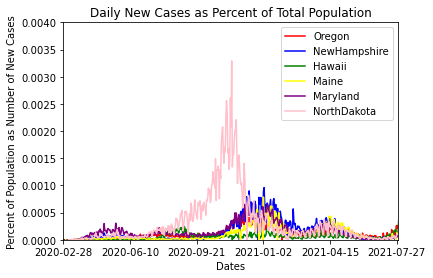

In [46]:
# Line plot showing number of new cases relative to population each day
plt.plot(Oregon['date'], Oregon['%newCases'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newCases'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newCases'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newCases'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newCases'], color='purple', label='Maryland')

plt.plot(NorthDakota['date'], NorthDakota['%newCases'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Cases as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Cases')
plt.xlim(0,517)
plt.ylim(0,0.0040)
plt.xticks(np.arange(0, 517, 103))
plt.savefig('Daily New Cases as Percent of Total Population.png')

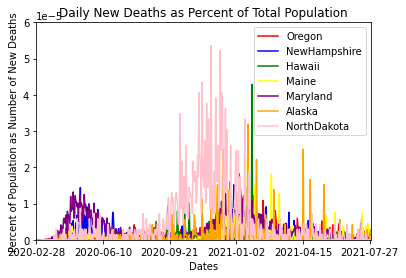

In [47]:
# Line plot showing number of deaths relative to population each day
plt.plot(Oregon['date'], Oregon['%newDeaths'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newDeaths'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newDeaths'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newDeaths'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newDeaths'], color='purple', label='Maryland')
plt.plot(Alaska['date'], Alaska['%newDeaths'], color='Orange', label='Alaska')
plt.plot(NorthDakota['date'], NorthDakota['%newDeaths'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Deaths as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Deaths')
plt.xlim(0,517)
plt.ylim(0,0.00006)
plt.xticks(np.arange(0, 517, 103))
plt.savefig('Daily New Deaths as Percent of Total Population.png')

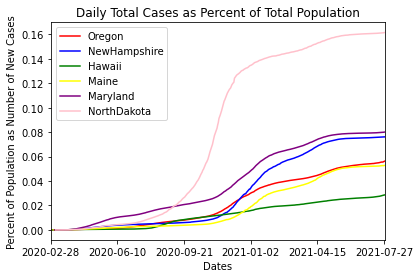

In [48]:
# Line plot showing number of new cases relative to population each day
plt.plot(Oregon['date'], Oregon['%cases'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%cases'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%cases'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%cases'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%cases'], color='purple', label='Maryland')
plt.plot(NorthDakota['date'], NorthDakota['%cases'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily Total Cases as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Cases')
plt.xlim(0,517)
#plt.ylim(0,0.0040)
plt.xticks(np.arange(0, 517, 103))
plt.savefig('Daily Total Cases as Percent of Total Population.png')

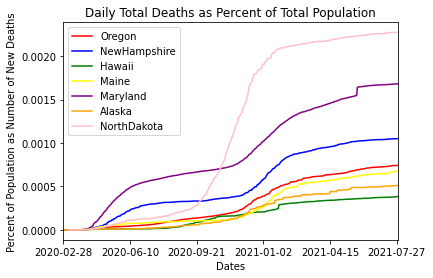

In [49]:
# Line plot showing number of deaths relative to population each day
plt.plot(Oregon['date'], Oregon['%deaths'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%deaths'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%deaths'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%deaths'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%deaths'], color='purple', label='Maryland')
plt.plot(Alaska['date'], Alaska['%deaths'], color='Orange', label='Alaska')
plt.plot(NorthDakota['date'], NorthDakota['%deaths'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily Total Deaths as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Deaths')
plt.xlim(0,517)
#plt.ylim(0,0.00006)
plt.xticks(np.arange(0, 517, 103))
plt.savefig('Daily Total Deaths as Percent of Total Population.png')

In [50]:
filtered_lockdown = lockdown_df[(lockdown_df['state']=='OR') | (lockdown_df['state']=='ND') | (lockdown_df['state']=='AK') | 
                                            (lockdown_df['state']=='HI') | (lockdown_df['state']=='ME') | (lockdown_df['state']=='MD')]
filtered_lockdown

,state,stay at home length
1,AK,27
12,HI,37
19,ME,59
20,MD,46
34,ND,0
37,OR,86


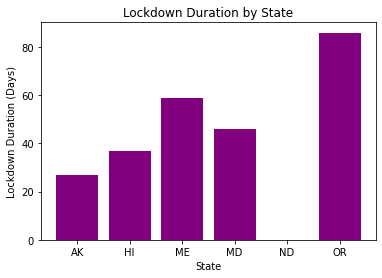

In [51]:

plt.bar(filtered_lockdown['state'], filtered_lockdown['stay at home length'],color=("purple"))
plt.title("Lockdown Duration by State")
plt.xlabel("State")
plt.ylabel("Lockdown Duration (Days)")
plt.savefig('Lockdown Duration by State.png')
plt.show()